pygame 2.1.2 (SDL 2.0.16, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


/tmp/ipykernel_2974999/531974237.py:174: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
Losses: [14560532.75716146]
Epoch 0, loss: 14560532.757161459, windowed_loss: 50


/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


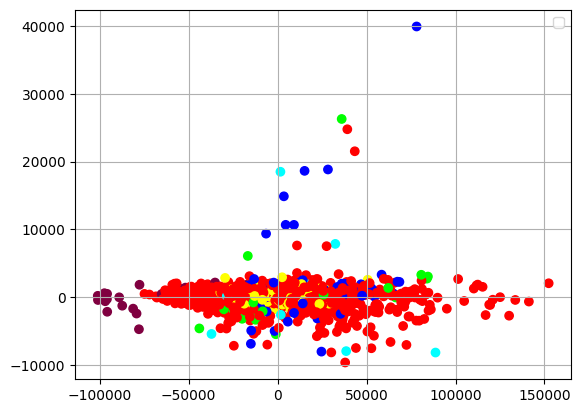

/tmp/ipykernel_2974999/531974237.py:174: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 0.0
Losses: [190769.59635417]
Epoch 1, loss: 190769.59635416666, windowed_loss: 50
Unsupervised Training.. 0.0
Losses: [6638.51175966]
Epoch 2, loss: 6638.511759662628, windowed_loss: 50
Unsupervised Training.. 0.0
Losses: [61620.51074219]
Epoch 3, loss: 61620.5107421875, windowed_loss: 50
Unsupervised Training.. 0.0
Losses: [153850.78307343]
Epoch 4, loss: 153850.7830734253, windowed_loss: 50
Unsupervised Training.. 0.0
Losses: [40680.22514038]
Epoch 5, loss: 40680.22514038086, windowed_loss: 50
Unsupervised Training.. 0.0
LR: [[0.48]]
Losses: [5448929.64858398]
Epoch 6, loss: 5448929.648583984, windowed_loss: 50
Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
LR: [[0.48]]
Losses: [849455.17610677]
Epoch 7, loss: 849455.1761067709, windowed_loss: 50
Unsupervised Training.. 0.0
LR: [[0.48]]
Losses: [25632.89936218]
Epoch 8, loss: 25632.899362182616, windowed_loss: 50
Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
LR: 

/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


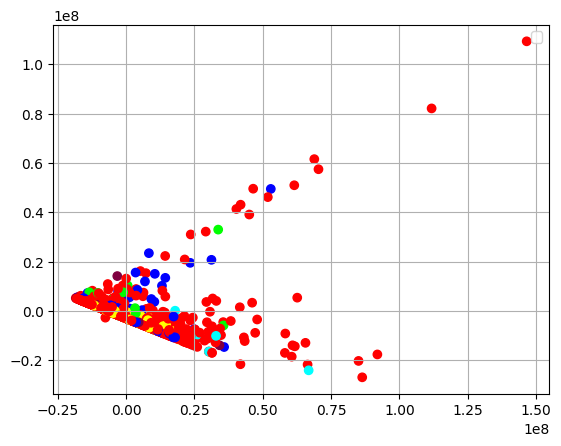

/tmp/ipykernel_2974999/531974237.py:174: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 0.0
LR: [[0.45599999999999996]]
Losses: [11606.546875]
Epoch 11, loss: 11606.546875, windowed_loss: 677415.0016487343
Unsupervised Training.. 0.0
LR: [[0.4331999999999999]]
Losses: [119038.0234375]
Epoch 12, loss: 119038.0234375, windowed_loss: 688654.952816518
Unsupervised Training.. 0.0
LR: [[0.4115399999999999]]
Losses: [183738.69140625]
Epoch 13, loss: 183738.69140625, windowed_loss: 700866.7708829243
Unsupervised Training.. 0.0
LR: [[0.4115399999999999]]
Losses: [6005.671875]
Epoch 14, loss: 6005.671875, windowed_loss: 686082.2597630818
Unsupervised Training.. 0.0
LR: [[0.4115399999999999]]
Losses: [0.]
Epoch 15, loss: 0.0, windowed_loss: 682014.2372490437
Unsupervised Training.. 0.0
LR: [[0.3909629999999999]]
Losses: [403.75557454]
Epoch 16, loss: 403.7555745442708, windowed_loss: 137161.64794809977
Unsupervised Training.. 0.0
LR: [[0.3714148499999999]]
Losses: [15290.975]
Epoch 17, loss: 15290.975, windowed_loss: 53745.22783742269
Unsupervised Training.. 

/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


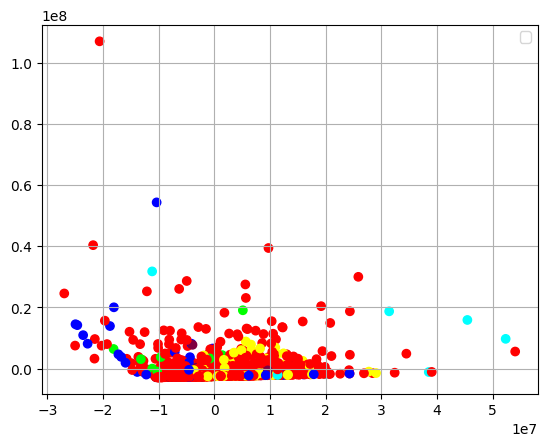

/tmp/ipykernel_2974999/531974237.py:174: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
LR: [[0.3528441074999999]]
Losses: [0.]
Epoch 21, loss: 0.0, windowed_loss: 34826.689800618486
Unsupervised Training.. 0.0
LR: [[0.3352019021249999]]
Losses: [0.]
Epoch 22, loss: 0.0, windowed_loss: 22922.88745686849
Unsupervised Training.. 0.0
LR: [[0.3184418070187499]]
Losses: [32708.175]
Epoch 23, loss: 32708.175, windowed_loss: 7819.835816243491
Unsupervised Training.. 0.0
LR: [[0.3184418070187499]]
Losses: [20.77487183]
Epoch 24, loss: 20.774871826171875, windowed_loss: 7221.346115926108
Unsupervised Training.. 0.0
LR: [[0.3025197166678124]]
Losses: [285633.3125]
Epoch 25, loss: 285633.3125, windowed_loss: 35784.67736592611
Unsupervised Training.. 0.0
LR: [[0.3025197166678124]]
Losses: [974.64489746]
Epoch 26, loss: 974.6448974609375, windowed_loss: 35841.76629821777
Unsupervised Training.. 0.0
LR: [[0.3025197166678124]]
Losses: [0.]
Epoch 27, loss: 0.0, windowed_loss: 34312.66879821777
Unsupervise

/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


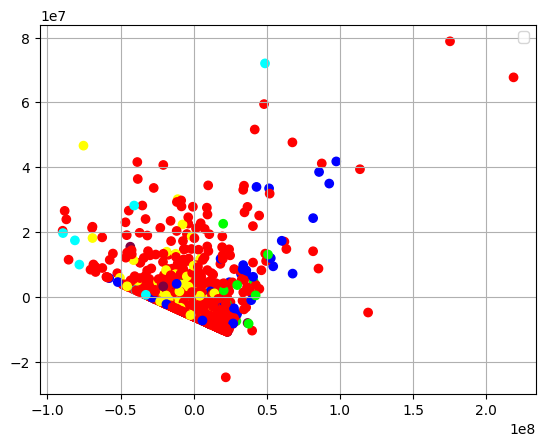

/tmp/ipykernel_2974999/531974237.py:174: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
LR: [[0.28739373083442177]]
Losses: [0.]
Epoch 31, loss: 0.0, windowed_loss: 68142.12455505371
Unsupervised Training.. 0.0
LR: [[0.27302404429270066]]
Losses: [0.]
Epoch 32, loss: 0.0, windowed_loss: 68142.12455505371
Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
LR: [[0.2593728420780656]]
Losses: [0.]
Epoch 33, loss: 0.0, windowed_loss: 64871.30705505371
Unsupervised Training.. 0.0
LR: [[0.2464041999741623]]
Losses: [0.]
Epoch 34, loss: 0.0, windowed_loss: 64869.229567871094
Unsupervised Training.. 0.0
LR: [[0.23408398997545418]]
Losses: [0.]
Epoch 35, loss: 0.0, windowed_loss: 36305.89831787109
Unsupervised Training.. 0.0
LR: [[0.22237979047668147]]
Losses: [143.81982422]
Epoch 36, loss: 143.81982421875, windowed_loss: 36222.815810546876
Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
LR: [[0.22237979047668147]]
Losses: [0.]
Epoch 37, loss: 0.0, windowed_loss: 36222.815810546876
Unsupervised Training.. 0.0
LR: 

/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


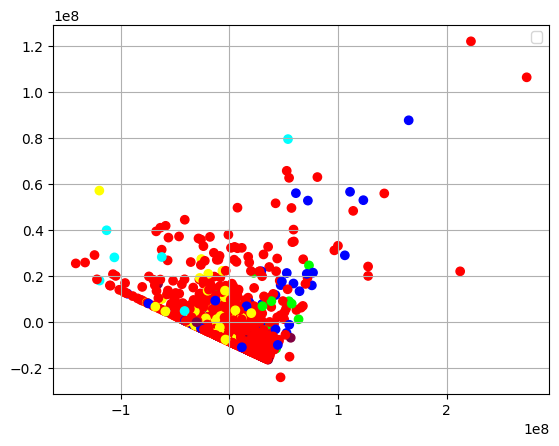

/tmp/ipykernel_2974999/531974237.py:174: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
LR: [[0.19066287285994474]]
Losses: [0.]
Epoch 41, loss: 0.0, windowed_loss: 12854.441982421875
Unsupervised Training.. 0.0
LR: [[0.1811297292169475]]
Losses: [0.]
Epoch 42, loss: 0.0, windowed_loss: 12854.441982421875
Unsupervised Training.. 0.0
LR: [[0.17207324275610011]]
Losses: [0.]
Epoch 43, loss: 0.0, windowed_loss: 12854.441982421875
Unsupervised Training.. 0.0
LR: [[0.1634695806182951]]
Losses: [0.]
Epoch 44, loss: 0.0, windowed_loss: 12854.441982421875
Unsupervised Training.. 0.0
LR: [[0.15529610158738036]]
Losses: [77815.7875]
Epoch 45, loss: 77815.7875, windowed_loss: 20636.020732421875
Unsupervised Training.. 0.0
LR: [[0.15529610158738036]]
Losses: [0.]
Epoch 46, loss: 0.0, windowed_loss: 20621.638750000002
Unsupervised Training.. 0.0
LR: [[0.14753129650801133]]
Losses: [0.]
Epoch 47, loss: 0.0, windowed_loss: 20621.638750000002
Unsupervised Training.. 0.0
LR: [[0.14015473168261075]]
Losses: [0.]
Epoch 48, loss: 0.0, w

/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


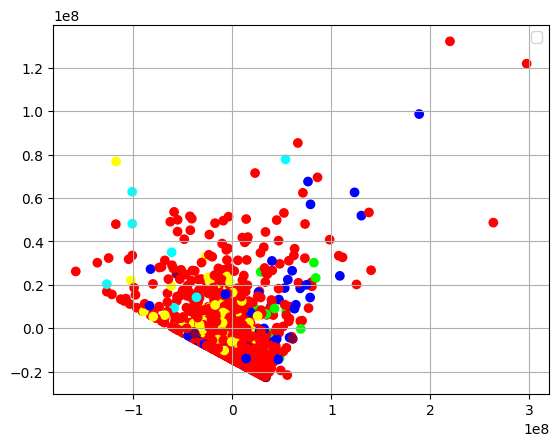

/tmp/ipykernel_2974999/531974237.py:174: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 0.0
LR: [[0.1264896453435562]]
Losses: [0.]
Epoch 51, loss: 0.0, windowed_loss: 7840.516225585938
Unsupervised Training.. 0.0
LR: [[0.12016516307637838]]
Losses: [106798.325]
Epoch 52, loss: 106798.325, windowed_loss: 18520.348725585936
Unsupervised Training.. 0.0
LR: [[0.12016516307637838]]
Losses: [0.]
Epoch 53, loss: 0.0, windowed_loss: 18520.348725585936
Unsupervised Training.. 0.0
LR: [[0.11415690492255946]]
Losses: [0.]
Epoch 54, loss: 0.0, windowed_loss: 18520.348725585936
Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
LR: [[0.10844905967643148]]
Losses: [0.]
Epoch 55, loss: 0.0, windowed_loss: 10738.769975585938
Unsupervised Training.. 0.0
LR: [[0.1030266066926099]]
Losses: [17.36486816]
Epoch 56, loss: 17.3648681640625, windowed_loss: 10740.506462402343
Unsupervised Training.. 0.0
LR: [[0.1030266066926099]]
Losses: [0.]
Epoch 57, loss: 0.0, windowed_loss: 10740.506462402343
Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
LR: [[0.0978752

/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


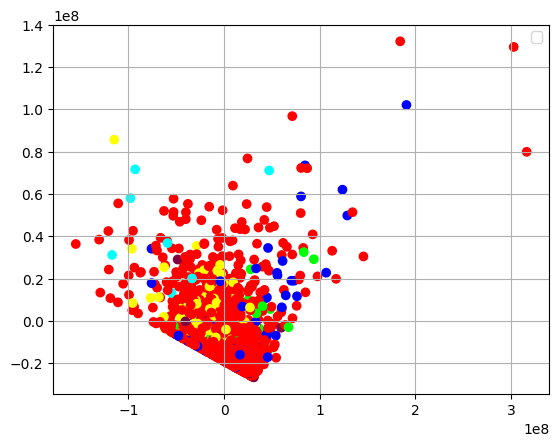

/tmp/ipykernel_2974999/531974237.py:174: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 0.0
LR: [[0.08391581506742259]]
Losses: [0.]
Epoch 61, loss: 0.0, windowed_loss: 10681.568986816406
Unsupervised Training.. 0.0
LR: [[0.07972002431405145]]
Losses: [0.]
Epoch 62, loss: 0.0, windowed_loss: 1.73648681640625
Unsupervised Training.. 0.0
LR: [[0.07573402309834888]]
Losses: [0.]
Epoch 63, loss: 0.0, windowed_loss: 1.73648681640625
Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
LR: [[0.07194732194343144]]
Losses: [0.]
Epoch 64, loss: 0.0, windowed_loss: 1.73648681640625
Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
LR: [[0.06834995584625986]]
Losses: [0.]
Epoch 65, loss: 0.0, windowed_loss: 1.73648681640625
Unsupervised Training.. 0.0
LR: [[0.06493245805394686]]
Losses: [906.70917969]
Epoch 66, loss: 906.7091796875, windowed_loss: 90.67091796874999
Unsupervised Training.. 0.0
LR: [[0.06493245805394686]]
Losses: [0.]
Epoch 67, loss: 0.0, windowed_loss: 90.67091796874999
Unsupervised Training.. 0.0
LR: [[0.061685835151249514]]
Losses: 

/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


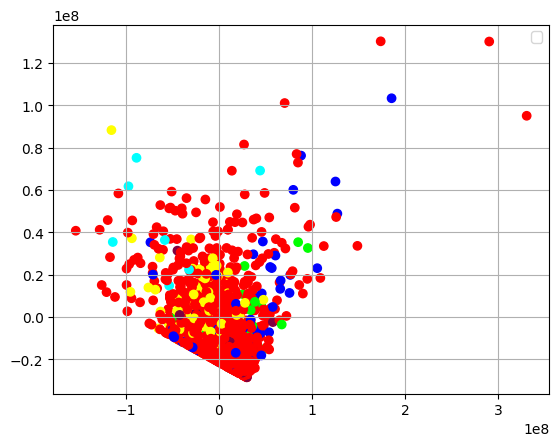

/tmp/ipykernel_2974999/531974237.py:174: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 0.0
LR: [[0.05567146622400268]]
Losses: [36140.1875]
Epoch 71, loss: 36140.1875, windowed_loss: 3799.5020214843753
Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
LR: [[0.05567146622400268]]
Losses: [3.18916829]
Epoch 72, loss: 3.1891682942708335, windowed_loss: 3799.820938313803
Unsupervised Training.. 0.0
LR: [[0.05567146622400268]]
Losses: [0.]
Epoch 73, loss: 0.0, windowed_loss: 3799.820938313803
Unsupervised Training.. 0.0
LR: [[0.05288789291280254]]
Losses: [0.]
Epoch 74, loss: 0.0, windowed_loss: 3799.820938313803
Unsupervised Training.. 0.0
LR: [[0.050243498267162415]]
Losses: [0.]
Epoch 75, loss: 0.0, windowed_loss: 3799.820938313803
Unsupervised Training.. 0.0
LR: [[0.04773132335380429]]
Losses: [62993.875]
Epoch 76, loss: 62993.875, windowed_loss: 10008.537520345053
Unsupervised Training.. 0.0
LR: [[0.04773132335380429]]
Losses: [0.]
Epoch 77, loss: 0.0, windowed_loss: 10008.537520345053
Unsupervised Training.. 0.0
LR: [[0.045344757186114075]]

/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


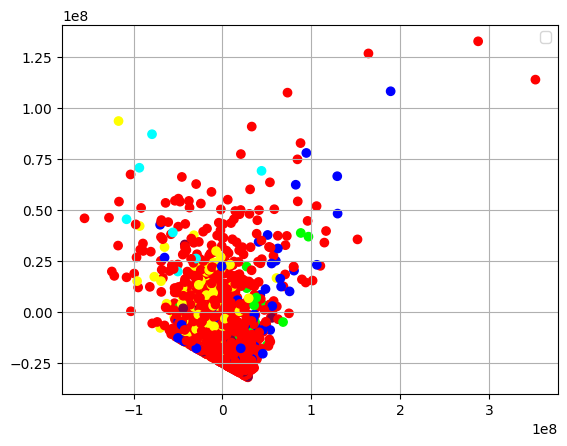

/tmp/ipykernel_2974999/531974237.py:174: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 0.0
LR: [[0.04092364336046795]]
Losses: [0.]
Epoch 81, loss: 0.0, windowed_loss: 17397.73610432943
Unsupervised Training.. 0.0
LR: [[0.03887746119244455]]
Losses: [0.]
Epoch 82, loss: 0.0, windowed_loss: 17397.4171875
Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
LR: [[0.03693358813282232]]
Losses: [0.]
Epoch 83, loss: 0.0, windowed_loss: 17397.4171875
Unsupervised Training.. 0.0
LR: [[0.0350869087261812]]
Losses: [300.89770508]
Epoch 84, loss: 300.897705078125, windowed_loss: 17427.506958007812
Unsupervised Training.. 0.0
LR: [[0.0350869087261812]]
Losses: [0.]
Epoch 85, loss: 0.0, windowed_loss: 17427.506958007812
Unsupervised Training.. 0.0
LR: [[0.033332563289872136]]
Losses: [0.]
Epoch 86, loss: 0.0, windowed_loss: 11128.119458007812
Unsupervised Training.. 0.0
LR: [[0.031665935125378526]]
Losses: [0.]
Epoch 87, loss: 0.0, windowed_loss: 11128.119458007812
Unsupervised Training.. 0.0
LR: [[0.0300826383691096]]
Losses: [0.]
Epoch 88, loss: 0.0, win

/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


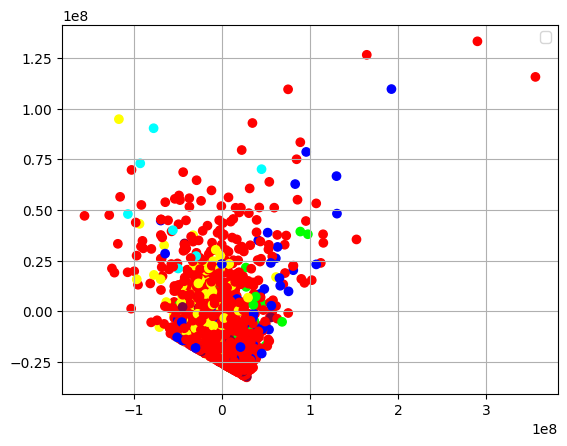

/tmp/ipykernel_2974999/531974237.py:174: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 0.0
LR: [[0.02579210207171534]]
Losses: [0.]
Epoch 91, loss: 0.0, windowed_loss: 30.0897705078125
Unsupervised Training.. 0.0
LR: [[0.02450249696812957]]
Losses: [0.]
Epoch 92, loss: 0.0, windowed_loss: 30.0897705078125
Unsupervised Training.. 0.0
LR: [[0.023277372119723094]]
Losses: [0.]
Epoch 93, loss: 0.0, windowed_loss: 30.0897705078125
Unsupervised Training.. 0.0
LR: [[0.022113503513736938]]
Losses: [0.]
Epoch 94, loss: 0.0, windowed_loss: 0.0
Total Pre-training Time: 497.0114667415619


In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scipy import ndimage
import torch
import time
import random
from data.swarmset import ContinuingDataset, SwarmDataset
from torchvision.transforms import RandomResizedCrop
from networks.embedding import NoveltyEmbedding
from networks.archive import DataAggregationArchive
import matplotlib.pyplot as plot
from networks.ensemble import Ensemble
import numpy as np
import cv2
from sklearn.manifold import TSNE

def CSVLineToVec(line):
    line_list = line.strip().replace("\n", "").split(",")
    float_list = []
    for i in line_list:
        float_list.append(float(i))
    float_list = np.array(float_list)
    return float_list

def visualize_projection(ensemble):
    embeddings = []
    classes = []
    # for i in range(len(data)):
    for i in range(1000):
        image, _class = sampled_dataset[i][0], sampled_dataset[i][1][0]
        image = np.expand_dims(image, axis=0)
        embed = ensemble.ensemble[0].forward(torch.tensor(image, device=device, dtype=torch.float))
        embed = embed.detach().cpu().squeeze(dim=0).numpy()
        embeddings.append(embed)
        classes.append(_class)

    embeddings = np.array(embeddings)

    reduced = TSNE(
        n_components=2,
        learning_rate="auto",
        init="pca",
        perplexity=40,
        early_exaggeration=1
    ).fit_transform(embeddings)

    color_classes = {
        -1: [0.33, 0.33, 0.33],
        0: [1, 0, 0],
        1: [0, 1, 0],
        2: [0, 0, 1],
        3: [0, 1, 1], # Cyan
        4: [1, 1, 0], # Yellow
        5: [0.5, 0, 0.25] # Pink
    }

    label_classes = {
        -1: "Unlabeled",
        0: "Random",
        1: "Cyclic Pursuit",
        2: "Milling",
        3: "Aggregation",
        4: "Dispersal",
        5: "Wall Following"
    }

    lim = len(reduced)
    classes = [-1 for i in range(lim)]

    OUT = "../data/oracle"
    with open(os.path.join(OUT, "original-hand-labeled-classes.txt"), "r") as f:
        lines = f.readlines()
        for line in lines:
            triplet = CSVLineToVec(line)
            classes[int(triplet[0])] = int(triplet[1])

    x = [reduced[i][0] for i in range(lim)]
    y = [reduced[i][1] for i in range(lim)]
    colors = [color_classes[classes[i]] for i in range(lim)]
    labels = [label_classes[classes[i]] for i in range(lim)]
    plot.grid(True)
    # plot.xlim(-5000, 20000)
    # plot.ylim(-15000, 10000)
    plot.scatter(x, y, c=colors)
    plot.legend()
    plot.show()

BATCH_SIZE = 4096
PRETRAINING = True
target = 0.0001
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.03 * BATCH_SIZE / 256
ensemble = Ensemble(size=1, output_size=5, lr_series=[lr], learning_decay=0.95, decay_step=1, threshold=None, weight_decay=10e-6, new_model=True, margin=1000)
ensemble.load_ensemble("../checkpoints/ensembles/full-mini-A", full=True)
sampled_dataset = SwarmDataset("../data/full-mini", rank=0)

def resizeInput(X, w=200):
    frame = X.astype(np.uint8)
    resized = cv2.resize(frame, dsize=(w, w), interpolation=cv2.INTER_AREA)
    return resized

def translate(img, offset=(10, 10)):
    h, w = img.shape
    xoff, yoff = offset
    if xoff < 0: xpadding = (0, -xoff)
    else: xpadding = (xoff, 0)
    if yoff < 0: ypadding = (0, -yoff)
    else: ypadding = (yoff, 0)
    img = np.pad(img, (xpadding, ypadding))

    if xoff >= 0 and yoff >= 0:
        return img[:w, :w]
    elif xoff < 0 and yoff >= 0:
        return img[-w:, :w]
    elif xoff >= 0 and yoff < 0:
        return img[:w, -w:]
    return img[-w:, -w:]

def zoom_at(img, zoom, coord=None):
    # Adapted from https://stackoverflow.com/questions/69050464/zoom-into-image-with-opencv
    h, w = [ zoom * i for i in img.shape ]
    if coord is None: cx, cy = w/2, h/2
    else: cx, cy = [ zoom*c for c in coord ]
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
               int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    return img

def get_color_distortion(X, s=3.0):
    X = X + s * np.random.randn(X.shape[0], X.shape[1])
    return X

def getRandomTransformation(image, k=2):
    transformation_choices = ["Rotation", "Blur", "Zoom", "Translate", "Distort", "ResizedCrop"]
    # weights = [0.4, 0.3, 0.0, 0.2]
    # weights = [1.0, 0.0, 0.0, 0.0]
    # choices = random.choices(transformation_choices, weights, k=k)
    choices = ["Distort", "ResizedCrop"]
    if "Rotation" in choices:
        theta = random.choice([90, 180, 270])
        image = ndimage.rotate(image, theta)
    elif "Blur" in choices:
        blur = random.choice([0.5, 1.0, 1.5])
        image = ndimage.gaussian_filter(image, sigma=blur)
    elif "Zoom" in choices:
        # zoom = random.choice([1.06, 1.12, 1.18])
        padding = random.choice([10])
        padded = np.pad(image, padding, mode='constant')
        image = resizeInput(padded, 50)
    elif "Translate" in choices:
        offsets = [i for i in range(-10, 10, 2)]
        offset = (random.choice(offsets), random.choice(offsets))
        # offset = (2, 2)
        image = translate(image, offset)
    elif "Distort" in choices:
        strength = random.choice([3.0, 5.0, 10.0])
        image = get_color_distortion(image, s=strength)
    elif "ResizedCrop" in choices:
        tmp = torch.tensor(image).unsqueeze(0)
        cropper = RandomResizedCrop(size=(50,50))
        image = cropper(image)
        image = image.squeeze(0)
    return image

def pretraining(data, ensemble, data_cutoff=None, data_size=500):
    if data_cutoff is None:
        data_cutoff = len(data) - 1
    # np.random.seed(0)
    samples = np.random.random_integers(0, data_cutoff, (data_size, 2))
    total_loss = np.array([0.0 for i in range(len(ensemble.ensemble))])
    total_updates = 0

    pull_set = [k for k in range(len(samples))]
    random.shuffle(pull_set)
    for index in range(0, len(pull_set), BATCH_SIZE):
        i = pull_set[index]
        if total_updates % 20 == 0:
            print(f"Unsupervised Training.. {(total_updates * BATCH_SIZE * 100) / data_size}")

        AUGMENT_SIZE = 1
        if i + (BATCH_SIZE * AUGMENT_SIZE) >= len(pull_set):
            continue

        temp_losses = np.array([0.0 for _ in ensemble.ensemble])

        anchors = np.array([data[samples[i + (j % AUGMENT_SIZE)][0]][0] for j in range(AUGMENT_SIZE * BATCH_SIZE)])
        positives = np.array([getRandomTransformation(data[samples[i + (j % AUGMENT_SIZE)][0]][0]) for j in range(AUGMENT_SIZE * BATCH_SIZE)])
        negatives = np.array([data[samples[i + (j % AUGMENT_SIZE)][1]][0] for j in range(AUGMENT_SIZE * BATCH_SIZE)])

        anchors = np.expand_dims(anchors, axis=1)
        positives = np.expand_dims(positives, axis=1)
        negatives = np.expand_dims(negatives, axis=1)

        losses = ensemble.train_batch(anchors, positives, negatives)
        temp_losses += losses

        total_loss += temp_losses
        total_updates += 1

    return total_loss, total_updates

t_1 = time.time()
LOSS_WINDOW = 10
if PRETRAINING:
    epochs = 0
    loss_history = []
    while loss > target:
        losses, total_updates = pretraining(sampled_dataset, ensemble, data_cutoff=None, data_size=20480)
        average_loss = losses / total_updates

        if epochs > 5:
            lr = ensemble.evaluate_lr(average_loss)
            print(f"LR: {lr}")

        locale_loss = sum(average_loss) / len(average_loss)
        loss_history.append(locale_loss)
        loss = (sum(loss_history[-LOSS_WINDOW:]) / LOSS_WINDOW) if len(loss_history) > LOSS_WINDOW else 50
        print(f"Losses: {average_loss}")
        print(f"Epoch {epochs}, loss: {locale_loss}, windowed_loss: {loss}")

        if epochs % 10 == 0:
            visualize_projection(ensemble)

        epochs += 1

print(f"Total Pre-training Time: {time.time() - t_1}")
ensemble.save_ensemble(f"../checkpoints/ensembles/{int(time.time())}", full=True)